In [1]:
import os
import shutil
from cv2 import *
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras_preprocessing import image


In [2]:
tf.keras.backend.clear_session()
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


In [5]:
kernel = np.ones((5,5), np.uint8)
train_path = 'chest_xray/train/'
new_train_path = 'New Images/Train'
for files in os.listdir(train_path):

    new_train_path2 = os.path.join(new_train_path,files)

    for f in os.listdir(train_path+files):

        img_path=os.path.join(train_path+files,f)
        norm=imread(img_path)
        norm=cvtColor(norm,COLOR_BGR2GRAY)
        th1=equalizeHist(norm)
        eroded = cv2.erode(th1, kernel)
        dilate = cv2.dilate(eroded,kernel)
        eroded2 = cv2.erode(dilate,kernel)

        new_train_path3 = os.path.join(new_train_path2,f)

        imwrite(new_train_path3,eroded2)

test_path = 'chest_xray/test/'
new_test_path = 'New Images/Test'

for files in os.listdir(test_path):

    new_test_path2 = os.path.join(new_test_path,files)

    for f in os.listdir(test_path+files):

        img_path=os.path.join(test_path+files,f)

        norm=imread(img_path)
        norm=cvtColor(norm,COLOR_BGR2GRAY)
        th1 = equalizeHist(norm)
        eroded = cv2.erode(th1, kernel)
        dilate = cv2.dilate(eroded, kernel)
        eroded2 = cv2.erode(dilate, kernel)

        new_test_path3 = os.path.join(new_test_path2,f)

        imwrite(new_test_path3, eroded2)


In [3]:
IMG_SIZE = 300

TRAINING_DIR = "New Images/Train"
training_datagen = ImageDataGenerator(rescale = 1/255 ,
                                  #     rotation_range=15,
                                  # height_shift_range=0.2,
                                  # width_shift_range=0.2,
                                  # shear_range=0.2,
                                  zoom_range=0.3,
                                  vertical_flip=True,
                                  fill_mode='nearest')
train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                       target_size=(IMG_SIZE,IMG_SIZE) ,class_mode='binary',
                                                       batch_size=64,shuffle=True )


TEST_DIR = "New Images/Test"
test_datagen = ImageDataGenerator(rescale = 1/255)
test_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=(IMG_SIZE,IMG_SIZE), class_mode='binary',
                                                  batch_size=64,
                                                  shuffle=False)

Found 6588 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
feature_extractor = tf.keras.applications.ResNet50V2(include_top=False,weights='imagenet',input_shape=(IMG_SIZE,IMG_SIZE,3))
feature_extractor.trainable = False

In [5]:
model = tf.keras.models.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 10, 10, 2048)      23564800  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2

In [6]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs['accuracy']>=0.975):
      self.model.stop_training=True

callbacks=myCallback()
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')]

checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=2, mode='max')

# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, mode='min')

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=METRICS )

history = model.fit(train_generator , epochs=20 , callbacks=[callbacks,checkpoint,lr_reduce], validation_data=test_generator)

Epoch 1/20
103/103 [==============================] - 272s 3s/step - loss: 0.2846 - accuracy: 0.8834 - precision: 0.8980 - recall: 0.9050 - val_loss: 0.1177 - val_accuracy: 0.9583 - val_precision: 0.9596 - val_recall: 0.9744
Epoch 2/20
103/103 [==============================] - 208s 2s/step - loss: 0.1670 - accuracy: 0.9367 - precision: 0.9480 - recall: 0.9444 - val_loss: 0.1430 - val_accuracy: 0.9439 - val_precision: 0.9340 - val_recall: 0.9795
Epoch 3/20
103/103 [==============================] - 242s 2s/step - loss: 0.1388 - accuracy: 0.9479 - precision: 0.9576 - recall: 0.9539 - val_loss: 0.1580 - val_accuracy: 0.9407 - val_precision: 0.9682 - val_recall: 0.9359
Epoch 4/20
103/103 [==============================] - 169s 2s/step - loss: 0.1231 - accuracy: 0.9534 - precision: 0.9647 - recall: 0.9560 - val_loss: 0.1035 - val_accuracy: 0.9615 - val_precision: 0.9575 - val_recall: 0.9821
Epoch 5/20
103/103 [==============================] - 170s 2s/step - loss: 0.1259 - accuracy: 0.9519

In [7]:
model.evaluate(test_generator, batch_size=32)

10/10 [==============================] - 5s 510ms/step - loss: 0.1081 - accuracy: 0.9599 - precision: 0.9620 - recall: 0.9744


[0.10810955613851547,
 0.9599359035491943,
 0.9620253443717957,
 0.9743589758872986]

In [8]:
model.save('model_with_975_early_stopping.h5')

Text(0.5, 1.0, &#39;Training and validation Recall&#39;)

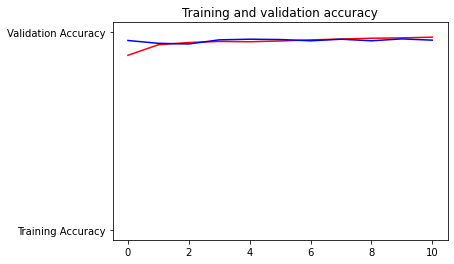

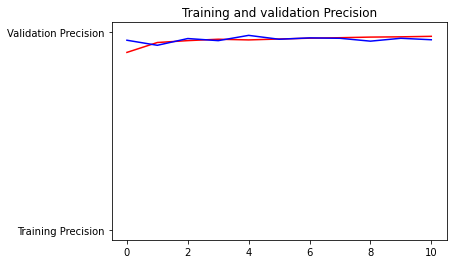

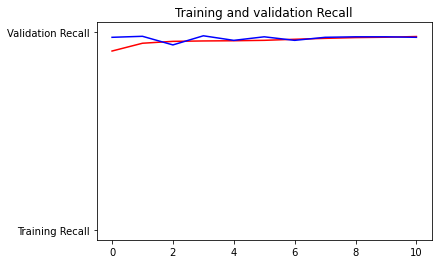

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
precision=history.history['precision']
val_precision=history.history['val_precision']
recall=history.history['recall']
val_recall=history.history['val_recall']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation Precision per epoch
#------------------------------------------------
plt.plot(epochs, precision, 'r', "Training Precision")
plt.plot(epochs, val_precision, 'b', "Validation Precision")
plt.title('Training and validation Precision')
plt.figure()

plt.plot(epochs, recall, 'r', "Training Recall")
plt.plot(epochs, val_recall, 'b', "Validation Recall")
plt.title('Training and validation Recall')

Loading the Saved Model


In [7]:
model =  tf.keras.models.load_model("model_with_975_early_stopping.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 10, 10, 2048)      23564800  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2

Predicting on Internet Images

In [69]:
kernel = np.ones((5,5), np.uint8)
val_path = 'New Images/Val'
for files in os.listdir(val_path):

    new_val_path2 = os.path.join(val_path,files)

    for f in os.listdir(new_val_path2):

        img_path=os.path.join(new_val_path2,f)
        norm=imread(img_path)
        norm=cvtColor(norm,COLOR_BGR2GRAY)
        th1=equalizeHist(norm)
        eroded = cv2.erode(th1, kernel)
        dilate = cv2.dilate(eroded,kernel)
        eroded2 = cv2.erode(dilate,kernel)
        eroded2 = resize(eroded2,(IMG_SIZE,IMG_SIZE))
        imwrite(img_path,eroded2)

In [8]:
IMG_SIZE=300
VAL_DIR = "New Images/Val"
val_datagen = ImageDataGenerator(rescale = 1/255)
val_generator = val_datagen.flow_from_directory(VAL_DIR,target_size=(IMG_SIZE,IMG_SIZE), class_mode='binary',shuffle=False)

Found 16 images belonging to 2 classes.


In [9]:
model.evaluate(val_generator)

1/1 [==============================] - 0s 2ms/step - loss: 0.0426 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000


[0.042608246207237244, 1.0, 1.0, 1.0]

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_classes(val_generator)
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, Y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(val_generator.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[8 0]
 [0 8]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00         8
   PNEUMONIA       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



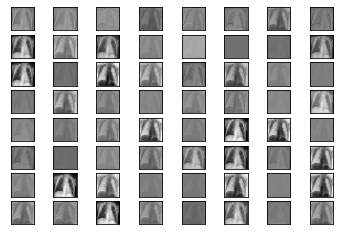

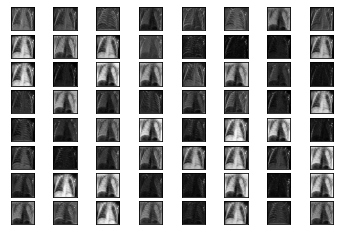

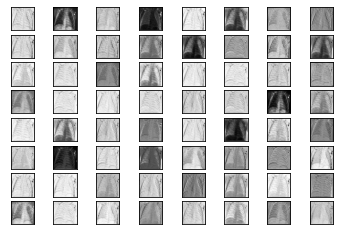

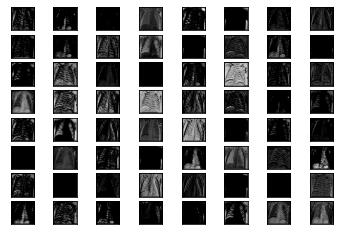

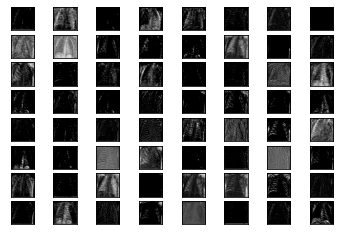

In [6]:
# visualize feature maps output from each block in the vgg model
import tensorflow as tf
from keras.applications.resnet_v2 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = tf.keras.applications.ResNet50V2(include_top=False,weights='imagenet',input_shape=(300,300,3))

    
# redefine model to output right after the first hidden layer
# print(model.summary())
ixs = [2, 5, 7, 10 ,25]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img('New Images/Train/PNEUMONIA/BACTERIA-49691-0001.jpeg', target_size=(300, 300))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	pyplot.show()